In [1]:
# initial setup
%run "../../../common/0_notebooks_base_setup.py"


/media/paulati/Nuevo vol/paula/dh/2021/dsad_2021_paula/common
default checking
Running command `conda list`... ok
jupyterlab=2.2.6 already installed
pandas=1.1.5 already installed
bokeh=2.2.3 already installed
seaborn=0.11.0 already installed
matplotlib=3.3.2 already installed
ipywidgets=7.5.1 already installed
pytest=6.2.1 already installed
chardet=4.0.0 already installed
psutil=5.7.2 already installed
scipy=1.5.2 already installed
statsmodels=0.12.1 already installed
scikit-learn=0.23.2 already installed
xlrd=2.0.1 already installed
Running command `conda install --yes nltk=3.5.0`... ok
Solving environment: ...working... done

# All requested packages already installed.


unidecode=1.1.1 already installed
pydotplus=2.0.2 already installed
pandas-datareader=0.9.0 already installed
flask=1.1.2 already installed


<img src="../../../common/logo_DH.png" align='left' width=50%/>

<a id="section_clasificando"></a>
# Detectando tumores malignos usando KNN

## Tabla de Contenidos
1. <a href='#section_intro'>Introducción</a>
2. <a href='#section_baseline'>Un modelo de base</a>
3. <a href='#section_optimizando'>Optimizando el valor de _k_</a>
4. <a href="#section_confusion">Matriz de confusión</a>
5. <a href="#section_conclusion">Conclusión</a>

---

<a id="section_intro"></a>
##  Introducción

En la notebook anterior, mostramos cómo funciona KNN aplicándolo un conjunto de datos sintéticos, de tan solo dos dimensiones, para poder generar una intuición visual acerca de cómo se comporta el algoritmo al momento de generar predicciones. En lo cotidiano, típicamente trabajaremos con datasets de mayor dimensionalidad, con los cuales ya no podremos visualizar las fronteras de decisión que genera KNN. Sin embargo, esto no significa que no podamos aplicar la técnica, ya que las medidas de distancia que podemos utilizar aplican a cualquier cantidad de dimensiones.

En esta notebook, vamos a trabajar con un dataset real de tumores mamarios con el objetivo de clasificar tumores benignos y malignos. Seguiremos los siguientes pasos:

1. Cargar el dataset desde el módulo correspondiente de Scikit-Learn
2. Preparar la matriz de _features_ y el vector *target*, separando los sets de _train_ y _test_
3. Correr una primera prueba de KNN con la configuración de hiperparámetros por defecto, que será nuestro modelo de base
4. Elegir el valor óptimo para el hiperparámetro `n_neighbors` utilizando validación cruzada
5. Repetir el proceso pero estandarizando la matriz de _features_ para analizar qué efecto tiene sobre la _performance_ del algoritmo
6. Graficar la matriz de confusión, una tabla que se utiliza comúnmente para inspeccionar visualmente los resultados de la clasificación

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#### 1. Cargar el dataset

In [3]:
# Cargamos el dataset y visualizamos su descripción
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
print(cancer.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

#### 2. Preparar la matriz de _features_ y el vector _target_

In [4]:
# Construimos la matriz de features y visualizamos las primeras filas
X = pd.DataFrame(cancer.data, columns = cancer.feature_names)
X.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [5]:
# Construimos el vector target y visualizamos las primeras filas
y = pd.Series(cancer.target)
y.sample(10)

377    1
50     1
106    1
412    1
375    1
56     0
525    1
357    1
70     0
409    1
dtype: int64

In [6]:
# Analizamos la proporción entre clases
pd.Series(y).value_counts(normalize=True).round(2)

1    0.63
0    0.37
dtype: float64

De acuerdo a la descripción del dataset, sabemos que la clase mayoritaria ($y=1$) corresponde a los tumores benignos, mientras que la minoritaria ($y = 0$) corresponde a los malignos. En este punto, es importante resaltar que **la etiqueta numérica asignada a cada clase es completamente arbitraria**. Si bien vamos a hablar comúnmente de **"clase positiva"** ($y=1$) y **"clase negativa"** ($y = 0$), esta nomenclatura es convencional y no guarda ningún tipo de valoración subjetiva al respecto de las cualidades de cada clase. Es decir, podríamos invertir las etiquetas y referirnos a los tumores malignos como clase positiva ($y=1$) y esto no traería aparejada ninguna complicación al momento de procesar los datos.

Hacemos el *train-test split*:

In [7]:
# El argumento stratify nos permite generar una división que respeta la misma proporción entre clases en ambos sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=12)

In [8]:
display(y_train.value_counts(normalize=True).round(2))
display(y_test.value_counts(normalize=True).round(2))

1    0.63
0    0.37
dtype: float64

1    0.63
0    0.37
dtype: float64

<a id="section_baseline"></a>
## Un modelo de base

Hecha la separación entre _train_ y *test*, ya podemos entrenar un KNN sobre este conjunto de datos. En esta primera prueba, trabajaremos con la configuración de los hiperparámetros del modelo que viene por defecto:

#### 3. Correr una primera prueba de KNN con la configuración de hiperparámetros por defecto

In [9]:
# Importamos la clase KNeighborsClassifier de módulo neighbors
from sklearn.neighbors import KNeighborsClassifier

In [10]:
# Instanciamos el modelo con su configuración por defecto
knn = KNeighborsClassifier()

In [11]:
# Ajustamos a los datos de entrenamiento
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [12]:
# Predecimos etiquetas para los datos de test
y_pred = knn.predict(X_test)

In [13]:
# Evaluamos el accuracy del modelo
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred).round(2)

0.92

Nuestro modelo puede clasificar correctamente el 92% de los tumores del set de *test*. ¡Nada mal para una línea de base!

<a id="section_optimizando"></a>
## Optimizando el valor de *k*

#### 4. Elegir el valor óptimo para el hiperparámetro `n_neighbors`

Ahora vamos a entrenar varios modelos de `KNeighborsClassifier` probando distintos valores posibles para el hiperparámetro `n_neighbors` dentro de un esquema de *cross-validation*:

In [14]:
# Vamos a querer graficar los distintos valores del score de cross validation
# en función del hiperparámetro n_neighbors. Para esto generamos una lista de
# diccionarios que después se puede convertir fácilmente en DataFrame.

# Probamos todos los enteros desde el 1 hasta el 20
# como posibles valores de n_neighbors a explorar.

# Definimos la estrategia de validación cruzada
from sklearn.model_selection import cross_val_score, KFold
kf = KFold(n_splits=5, shuffle=True, random_state=12)

scores_para_df = []

for i in range(1, 21):
    
    # En cada iteración, instanciamos el modelo con un hiperparámetro distinto
    model = KNeighborsClassifier(n_neighbors=i)
    
    # cross_val_scores nos devuelve un array de 5 resultados,
    # uno por cada partición que hizo automáticamente CV
    cv_scores = cross_val_score(model, X_train, y_train, cv=kf)
    
    # Para cada valor de n_neighbours, creamos un diccionario con el valor
    # de n_neighbours y la media y el desvío de los scores
    dict_row_score = {'score_medio':np.mean(cv_scores),
                      'score_std':np.std(cv_scores), 'n_neighbors':i}
    
    # Guardamos cada uno en la lista de diccionarios
    scores_para_df.append(dict_row_score)

In [15]:
# Creamos el DataFrame a partir de la lista de diccionarios
df_scores = pd.DataFrame(scores_para_df)
df_scores.head()

,score_medio,score_std,n_neighbors
0,0.906074,0.026914,1
1,0.903721,0.029294,2
2,0.915513,0.027165,3
3,0.903721,0.029294,4
4,0.910780,0.032984,5


##### Graficando la búsqueda del mejor hiperparámetro

El valor de _scoring_ que utiliza por defecto `KNeighborsClassifier` es el accuracy, el porcentaje de casos bien clasificados. 

Una vez que tenemos la tabla con la _performance_ para cada valor del hiperparámetro, hacemos un gráfico con los valores obtenidos. Para darnos una idea de la dispersión, vamos a graficar también las líneas que indican un desvío estándar por encima y por debajo de la media. 

In [16]:
# Generamos los límites inferior y superior
df_scores['limite_inferior'] = df_scores['score_medio'] - df_scores['score_std']
df_scores['limite_superior'] = df_scores['score_medio'] + df_scores['score_std']
df_scores.head()

,score_medio,score_std,n_neighbors,limite_inferior,limite_superior
0,0.906074,0.026914,1,0.879160,0.932988
1,0.903721,0.029294,2,0.874427,0.933015
2,0.915513,0.027165,3,0.888348,0.942678
3,0.903721,0.029294,4,0.874427,0.933015
4,0.910780,0.032984,5,0.877795,0.943764


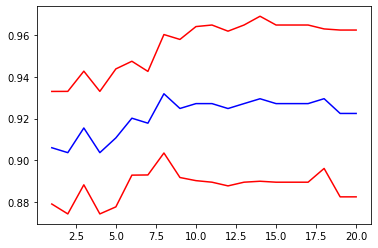

In [17]:
# Graficamos los resultados
plt.plot(df_scores['n_neighbors'], df_scores['limite_inferior'], color='r')
plt.plot(df_scores['n_neighbors'], df_scores['score_medio'], color='b')
plt.plot(df_scores['n_neighbors'], df_scores['limite_superior'], color='r');

In [18]:
# Identificamos el score máximo
df_scores.loc[df_scores.score_medio == df_scores.score_medio.max()]

,score_medio,score_std,n_neighbors,limite_inferior,limite_superior
7,0.931874,0.028318,8,0.903556,0.960192


Luego de la validación cruzada, identificamos que el valor de `n_neighbors` que maximiza el *score* promedio es 8.

#### 5. Repetir el proceso pero estandarizando la matriz de *features*

Dijimos que KNN es un método de _machine learning_ que se basa en calcular distancia. Entonces, **lo correcto sería estandarizar las variables para eliminar sus distintas unidades de medida y evitar distorsiones debidas a diversas escalas**, cosa que adrede no hemos hecho en los pasos anteriores. Ahora, vamos a repetir el procedimiento pero estandarizando previamente las variables con `StandardScaler` y compararemos los nuevos resultados con los anteriormente obtenidos. 

In [19]:
# Utilizamos sklearn para estandarizar la matriz de features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [20]:
# Verificamos que las variables ahora tengan media 0 y desvío 1.
print('Medias:', np.mean(X_train, axis=0).round(2))
print('Desvio:', np.std(X_train, axis=0).round(2))

Medias: [-0. -0. -0. -0. -0. -0. -0.  0.  0.  0.  0. -0.  0. -0.  0.  0.  0.  0.
  0.  0. -0.  0.  0. -0.  0.  0. -0.  0. -0.  0.]
Desvio: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]


In [21]:
# Calculamos nuevamente los scores de cross validation,
# pero esta vez sobre los features estandarizados:

scores_para_df_standard = []

for i in range(1, 21):
    model = KNeighborsClassifier(n_neighbors=i)
    cv_scores = cross_val_score(model, X_train, y_train, cv=kf)
    dict_row_score = {'score_medio':np.mean(cv_scores),
                      'score_std':np.std(cv_scores), 'n_neighbors':i}
    scores_para_df_standard.append(dict_row_score)

In [22]:
# Creamos el DataFrame a partir de la lista de diccionarios
df_scores_standard = pd.DataFrame(scores_para_df_standard)
df_scores_standard.head()

,score_medio,score_std,n_neighbors
0,0.957729,0.015996,1
1,0.950643,0.020311,2
2,0.960082,0.012031,3
3,0.964788,0.007442,4
4,0.962462,0.008689,5


In [23]:
# Armamos nuevamente los límites para graficar
df_scores_standard['limite_superior'] = df_scores_standard['score_medio'] + df_scores_standard['score_std']
df_scores_standard['limite_inferior'] = df_scores_standard['score_medio'] - df_scores_standard['score_std']
df_scores_standard.head()

,score_medio,score_std,n_neighbors,limite_superior,limite_inferior
0,0.957729,0.015996,1,0.973725,0.941734
1,0.950643,0.020311,2,0.970954,0.930332
2,0.960082,0.012031,3,0.972113,0.948051
3,0.964788,0.007442,4,0.972230,0.957345
4,0.962462,0.008689,5,0.971151,0.953774


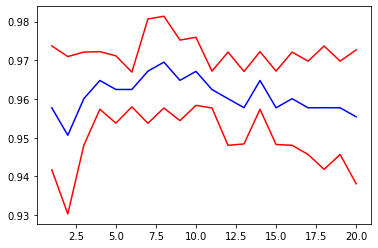

In [24]:
# Graficamos los resultados
plt.plot(df_scores_standard['n_neighbors'], df_scores_standard['limite_inferior'], color='r')
plt.plot(df_scores_standard['n_neighbors'], df_scores_standard['score_medio'], color='b')
plt.plot(df_scores_standard['n_neighbors'], df_scores_standard['limite_superior'], color='r');

In [25]:
# Identificamos el score máximo
df_scores_standard.loc[df_scores_standard.score_medio == df_scores_standard.score_medio.max()]

,score_medio,score_std,n_neighbors,limite_superior,limite_inferior
7,0.969521,0.011849,8,0.98137,0.957673


Si bien el valor de _k_ óptimo vuelve a ser el mismo que antes, notamos que el _score_ promedio de la validación cruzada es varios puntos más alto que el que habíamos alcanzado sin la estandarización de las variables.

Ahora que decidimos cuál es el mejor preprocesamiento y el mejor valor posible para el hiperparámetro `n_neighbors`, podemos reentrenar el modelo y evaluar los resultados sobre _test_.

In [26]:
# Asignamos el valor del k óptimo a una variable
best_k = df_scores_standard.loc[df_scores_standard.score_medio == df_scores_standard.score_medio.max(), 'n_neighbors'].values[0]
best_k

8

In [27]:
# Elegimos el modelo óptimo de acuerdo a las pruebas de cross validation
model = KNeighborsClassifier(n_neighbors=best_k)

# Lo ajustamos sobre los datos de entrenamiento
model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=8)

In [28]:
# Evaluamos qué accuracy obtenemos en train
accuracy_score(y_train, model.predict(X_train)).round(2)

0.97

En línea con los resultados que habíamos durante las pruebas de validación cruzada, nuestro KNN está alcanzando un _accuracy score_ del orden del 97% sobre los datos de entrenamiento. Veamos si es capaz de generalizar sobre el conjunto de testeo con una _performance_ similar.

In [29]:
# Lo utilizamos para predecir en test
X_test = scaler.transform(X_test) # ¡Importantísimo estandarizar también los datos de test con las medias y desvíos aprendidos en train!
y_pred = model.predict(X_test)

In [30]:
# Evaluamos el accuracy del modelo en test
accuracy_score(y_test, y_pred).round(2)

0.96

¡Excelente! Nuestro modelo tiene una muy buena capacidad de generalización, pudiendo clasificar correctamente al 96% de los tumores de *test*.

<a id="section_confusion"></a>
## Matriz de confusión

Además de evaluar la capacidad predictiva del modelo a partir del *accuracy*, queremos contar con un poco más de detalle acerca de los resultados de nuestro clasificador. Para esto, generaremos la matriz de confusión, una tabla que muestra los aciertos y desaciertos del modelo.

El método `confusion_matrix()`, propio del módulo de métricas de Scikit-Learn, nos permite generar rápidamente una tabla de doble entrada que compara las etiquetas reales (eje vertical) con las etiquetas predichas (eje horizontal).

In [31]:
# Obtenemos la matriz de confusión
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[50,  3],
       [ 3, 87]])

#### 6. Graficar la matriz de confusión

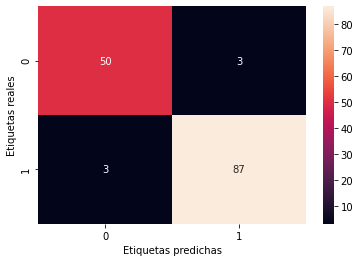

In [32]:
# Graficamos la matriz de confusión para visualizarla mejor
sns.heatmap(cm, annot=True)
plt.ylabel('Etiquetas reales')
plt.xlabel('Etiquetas predichas');

¿Cómo interpretamos esta tabla?

- La primera fila corresponde a los casos negativos reales (tumores malignos) y la segunda, a los casos positivos reales (tumores benignos).
- La primera columna corresponde a los casos negativos predichos (tumores malignos) y la segunda, a los casos positivos predichos (tumores benignos).
- En la diagonal de la matriz se encuentran las clasificaciones correctas: nuestro modelo detectó correctamente 50 tumores malignos y 87 tumores benignos.
- Los elementos por fuera de la diagonal indican las confusiones del modelo (de ahí el nombre de la matriz): nuestro modelo confunde 3 tumores malignos y 3 tumores benignos, asignándoles etiquetas incorrectas.

In [33]:
# Podemos calcular manualmente la exactitud de nuestro modelo...
((cm[0,0] + cm[1,1]) / len(y_pred)).round(2)

0.96

In [34]:
# ... o computarla utilizando el método del accuracy score
accuracy_score(y_test, y_pred).round(2)

0.96

Pese a ser un modelo de _machine learning_ de los más sencillos, aplicando KNN sobre el dataset de cáncer de mama podemos distinguir con un 96% de exactitud los tumores benignos de los malignos.

Más adelante, estudiaremos otras métricas de evaluación, distintas al *accuracy*, que también surgen de la matriz de confusión.

<a id="section_conclusion"></a>
## Conclusión

<br>
<div id="caja9" style="float:left;width: 100%;">
  <div style="float:left;width: 15%;"><img src="../../../common/icons/kit_de_salida.png"/> </div>
  <div style="float:left;width: 85%;"><label>Vimos una aplicación de <b>KNN</b> a un problema real, relevante en el ámbito de la medicina: entrenamos un modelo de clasificación que permite distinguir tumores benignos de malignos. Hicimos pruebas para distintos valores del hiperparámetro <i>k</i> del modelo, y elegimos el valor óptimo siguiendo la estrategia de <b>validación cruzada</b>. Mostramos <b>la importancia de estandarizar las <i>features</i></b> como paso necesario en la etapa de preprocesamiento de los datos cuando trabajamos con modelos que se basan en calcular distancias. Por último, presentamos la <b>matriz de confusión</b>, una herramienta fundamental al momento de analizar los resultados de un clasificador.</label></div>
</div>